### **Построение модели кредитного скоринга**
**Постановка задачи**

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### **Описание этапов выполнения проектов**

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### **Обзор данных**

**Пути к директориям файлов**

In [414]:
#input
TRAIN_DATASET_PATH = '/home/red/Documents/course_project_train.csv'
TEST_DATASET_PATH = '/home/red/Documents/course_project_test.csv'

#output
MODEL_FILE_PATH = '/home/red/Documents/model.pkl'

**Подключение библиотек и скриптов**

In [415]:
import pandas as pd
import numpy as np

import pickle

from scipy.stats import mode
from scipy import stats

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import matplotlib
import matplotlib.image as img
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm

import seaborn as sns
from matplotlib import pyplot as plt
import missingno as miss
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [416]:
def dummies_short_long(df, col_name, new_col_name):
    df[new_col_name] = df[col_name].replace({'Short Term':0, 'Long Term':1})
    return df[new_col_name]

In [417]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [418]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Загрузка данных**

In [419]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [420]:
df_train.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [421]:
df_train.shape

(7500, 17)

In [422]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Пропуски данных в переменных:**
1) Annual Income,<br>
2) Years in current job,<br>
3) Months since last delinquent,<br>
4) Bankruptcies,<br>
5) Credit Score

In [423]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Целевая переменная**

In [424]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [425]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [426]:
df_test.shape

(2500, 16)

### Обзор количественных переменных

In [427]:
df_num_features = df_train.select_dtypes(include=['float', 'int'])
df_num_features.drop('Credit Default', axis=1, inplace=True)
df_num_features.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,99999999.0,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,99999999.0,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,125840.0,93309.0,7180.0,719.0


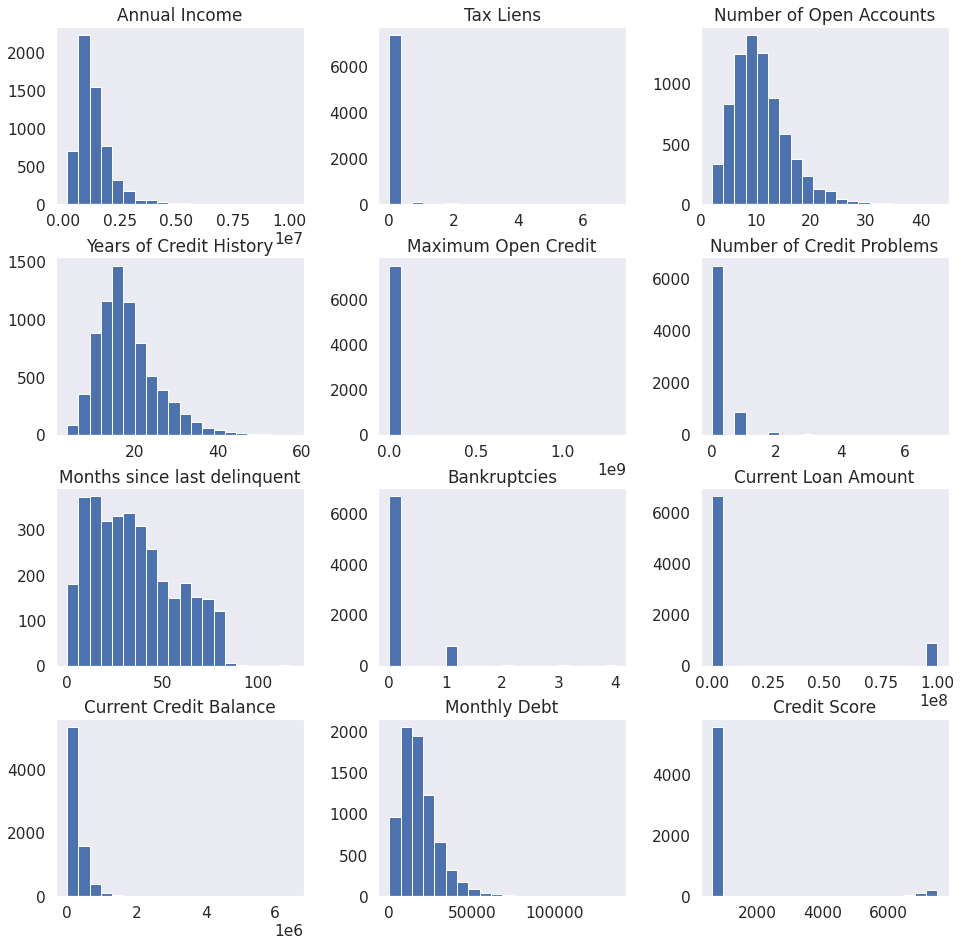

In [428]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

**'Annual Income'** 

In [429]:
df_train['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

**Tax Liens** 

In [430]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

Tax Liens имеет значение 0 для 7366 значений, только 134 значения имеют какие-то значения

**'Maximum Open Credit'**

**Явно имеютс выбросы, так как есть очень большие значения в соотношении к годовому доходу.**

In [431]:
df_train['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

**Number of Credit Problems**

In [432]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

**Current Loan Amount** <br>
Имеются выбросы 99999999.0 - 870 шт<br>

In [433]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
216106.0        5
265826.0        5
             ... 
104324.0        1
201080.0        1
427812.0        1
665544.0        1
191136.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

**Monthly Debt**

в датасете есть случаи когда  Monthly Debt больше половины месячного дохода, но их всего 18, ничего не буду с этим делать, возможно это нормально

**Анализ 'Credit Score'**

*Значения Credit score разделились на 2 группы: 1) - от 600 до 750 2) - от 6100 до 7500, очевидно что во второй группе приписан лишний ноль*

### Дополнительный анализ зависимостей переменных

**Новые Фичи**

In [434]:
df_train['monthly_ratio'] = 0

In [435]:
df_train.loc[df_train['monthly_ratio'], 'monthly_ratio'] = df_train['Annual Income']/(12 * df_train['Monthly Debt'])

In [436]:
df_train['current_credit_bal_annual_incom']=0

In [437]:
df_train.loc[df_train['current_credit_bal_annual_incom'], 'current_credit_bal_annual_incom'] = df_train['Annual Income']* df_train['Current Credit Balance']

In [438]:
new_features = ['monthly_ratio', 'current_credit_bal_annual_incom']

### Обзор номинативных переменных

In [439]:
df_obj_features = df_train.select_dtypes(include='object')
df_obj_features.head()

,Home Ownership,Years in current job,Purpose,Term
0,Own Home,NaN,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term


In [440]:
cat_colnames = df_obj_features.columns.tolist()
cat_colnames

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [441]:
for cat_colname in cat_colnames[:]:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**Home Ownership**

в переменной Home Ownership, есть 2 значения Home Mortgage (3637) и Have Mortgage (12), на мой взгляд это одно и тоже

### Заполнение пропусков

**Пропуски данных в переменных:**
1) Annual Income,<br>
2) Years in current job,<br>
3) Months since last delinquent,<br>
4) Bankruptcies,<br>
5) Credit Score

**Annual Income**<br>
Заполняю пропуски медианой #средним значением

In [442]:
df_train['Annual Income'].isna().sum()

1557

In [443]:
median_ai = df_train['Annual Income'].median()

In [444]:
df_train['Annual Income'] = df_train['Annual Income'].fillna(median_ai)

**Years in current job**

Создаем дополнительную переменную указывающую на то что был заполнен пропуск в этой линии

In [445]:
df_train['Years in current job nan'] = 0 

In [446]:
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job nan'] = 1

In [447]:
df_train['Years in current job'].isna().sum()

371

Находим моду и заполняем ею пропуски

In [448]:
mode_yicj = df_train['Years in current job'].mode()[0]
mode_yicj

'10+ years'

In [449]:
df_train['Years in current job'] = df_train['Years in current job'].fillna(mode_yicj)

Аналогично для 'Bankruptcies', 'Months since last delinquent', 'Credit Score', только заполняем медианой

In [450]:
df_train['Bankruptcies_nan'] = 0

In [451]:
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies_nan'] = 1

In [452]:
df_train['Bankruptcies'].isna().sum()  

14

In [453]:
median_b = df_train['Bankruptcies'].median()
median_b

0.0

In [454]:
df_train['Bankruptcies'] = df_train['Bankruptcies'].fillna(median_b)

In [455]:
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [456]:
df_train['Months since last delinquent nan'] = 0

In [457]:
df_train.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent nan'] = 1

In [458]:
median_msld = df_train['Months since last delinquent'].median()
median_msld

32.0

In [459]:
df_train['Months since last delinquent'] = df_train['Months since last delinquent'].fillna(median_msld)

In [460]:
df_train['Months since last delinquent'].isna().sum()

0

In [461]:
df_train['Credit Score nan'] = 0

In [462]:
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score nan'] = 1

In [463]:
median_cs = df_train['Credit Score'].median()
median_cs

731.0

In [464]:
df_train['Credit Score'] = df_train['Credit Score'].fillna(median_cs)

In [465]:
df_train['Credit Score'].isna().sum()

0

## Обработка датасетов

### Обработка номинативных переменных

Преобразования Purpose<br> 
редкие признаки уберем в other и переименуем other в other_purpose

In [466]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [467]:
df_train.replace(
    {'Purpose':
        {'other': 'other_purpose',
        'renewable energy' :'other_purpose',
        'vacation': 'other_purpose'
        }
    },
    inplace=True)

Уберу знак < чтобы не было ошибки

In [468]:
df_train.replace(
    {'Years in current job':
     {'< 1 year': 'less_than_1_year'}
     }, 
     inplace=True)

в переменной Home Ownership, есть 2 значения Home Mortgage (3637) и Have Mortgage (12), на мой взгляд это одно и тоже

In [469]:
df_train.replace(
    {'Home Ownership':
        {'Have Mortgage': 'Home Mortgage'}
    },
    inplace=True)

In [470]:
df_bin_features_Home_Ownership = pd.get_dummies(df_train['Home Ownership'])

In [471]:
df_bin_features_Years_in_current_job = pd.get_dummies(df_train['Years in current job'])

In [472]:
df_bin_features_Purpose = pd.get_dummies(df_train['Purpose'])

In [473]:
df_train = pd.concat([df_train, df_bin_features_Purpose, df_bin_features_Years_in_current_job, df_bin_features_Home_Ownership], axis=1)

In [474]:
df_train['Term_bin'] = dummies_short_long(df_train, 'Term', 'Term_bin')

In [475]:
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,5 years,6 years,7 years,8 years,9 years,less_than_1_year,Home Mortgage,Own Home,Rent,Term_bin
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,...,0,0,0,0,0,0,0,1,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,1,0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,...,0,0,0,1,0,0,1,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,...,0,1,0,0,0,0,0,1,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,less_than_1_year,0.0,3.0,8.5,107866.0,0.0,32.0,0.0,...,0,0,0,0,0,1,0,0,1,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,...,0,0,0,0,0,0,1,0,0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,32.0,0.0,...,0,1,0,0,0,0,0,0,1,0
7498,Home Mortgage,1168386.0,10+ years,0.0,21.0,26.5,1141250.0,0.0,32.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [476]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 51 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Home Ownership                    7500 non-null   object 
 1   Annual Income                     7500 non-null   float64
 2   Years in current job              7500 non-null   object 
 3   Tax Liens                         7500 non-null   float64
 4   Number of Open Accounts           7500 non-null   float64
 5   Years of Credit History           7500 non-null   float64
 6   Maximum Open Credit               7500 non-null   float64
 7   Number of Credit Problems         7500 non-null   float64
 8   Months since last delinquent      7500 non-null   float64
 9   Bankruptcies                      7500 non-null   float64
 10  Purpose                           7500 non-null   object 
 11  Term                              7500 non-null   object 
 12  Curren

In [477]:
total_features = df_train.columns.tolist()
print(total_features)

['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Default', 'monthly_ratio', 'current_credit_bal_annual_incom', 'Years in current job nan', 'Bankruptcies_nan', 'Months since last delinquent nan', 'Credit Score nan', 'business loan', 'buy a car', 'buy house', 'debt consolidation', 'educational expenses', 'home improvements', 'major purchase', 'medical bills', 'moving', 'other_purpose', 'small business', 'take a trip', 'wedding', '1 year', '10+ years', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', 'less_than_1_year', 'Home Mortgage', 'Own Home', 'Rent', 'Term_bin']


In [478]:
total_features.remove('Credit Default')
print(len(total_features))

50


In [479]:
obj_features = df_obj_features.columns.tolist()
obj_features
print(len(obj_features))

4


In [480]:
total_num_features = total_features

for obj_feature in obj_features:
    total_num_features.remove(obj_feature)
    
print(total_num_features)
print(len(total_num_features))

['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'monthly_ratio', 'current_credit_bal_annual_incom', 'Years in current job nan', 'Bankruptcies_nan', 'Months since last delinquent nan', 'Credit Score nan', 'business loan', 'buy a car', 'buy house', 'debt consolidation', 'educational expenses', 'home improvements', 'major purchase', 'medical bills', 'moving', 'other_purpose', 'small business', 'take a trip', 'wedding', '1 year', '10+ years', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', 'less_than_1_year', 'Home Mortgage', 'Own Home', 'Rent', 'Term_bin']
46


In [481]:
num_features = df_num_features.columns.tolist()
num_features += new_features
print(num_features)
print(len(num_features))

['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'monthly_ratio', 'current_credit_bal_annual_incom']
14


In [482]:
binary_features = total_num_features[:]
for num_feature in num_features:
    binary_features.remove(num_feature)
print(binary_features)
print(len(binary_features))

['Years in current job nan', 'Bankruptcies_nan', 'Months since last delinquent nan', 'Credit Score nan', 'business loan', 'buy a car', 'buy house', 'debt consolidation', 'educational expenses', 'home improvements', 'major purchase', 'medical bills', 'moving', 'other_purpose', 'small business', 'take a trip', 'wedding', '1 year', '10+ years', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', 'less_than_1_year', 'Home Mortgage', 'Own Home', 'Rent', 'Term_bin']
32


In [483]:
for i in binary_features:
    df_train[i] = df_train[i].astype(np.int8)

total_features - все фичи кроме целевой<br>
obj_features - категориальные фичи<br>
total_num_features - все фичи кроме категориальных (они здесь в виде бинарных)<br>
num_features - числовые фичи<br>
binary_features - бинарные фичи(преобразованные категориальные и дополнительные связанные с заполнением пропусков)<br>
new_features - новые фичи<br>
final_features - окончательные фичи<br>
non_important_features - малозначимые фичи<br>

In [484]:
FEATURE_NAMES = total_num_features
TARGET_NAME = 'Credit Default'

### Значимость признаков¶

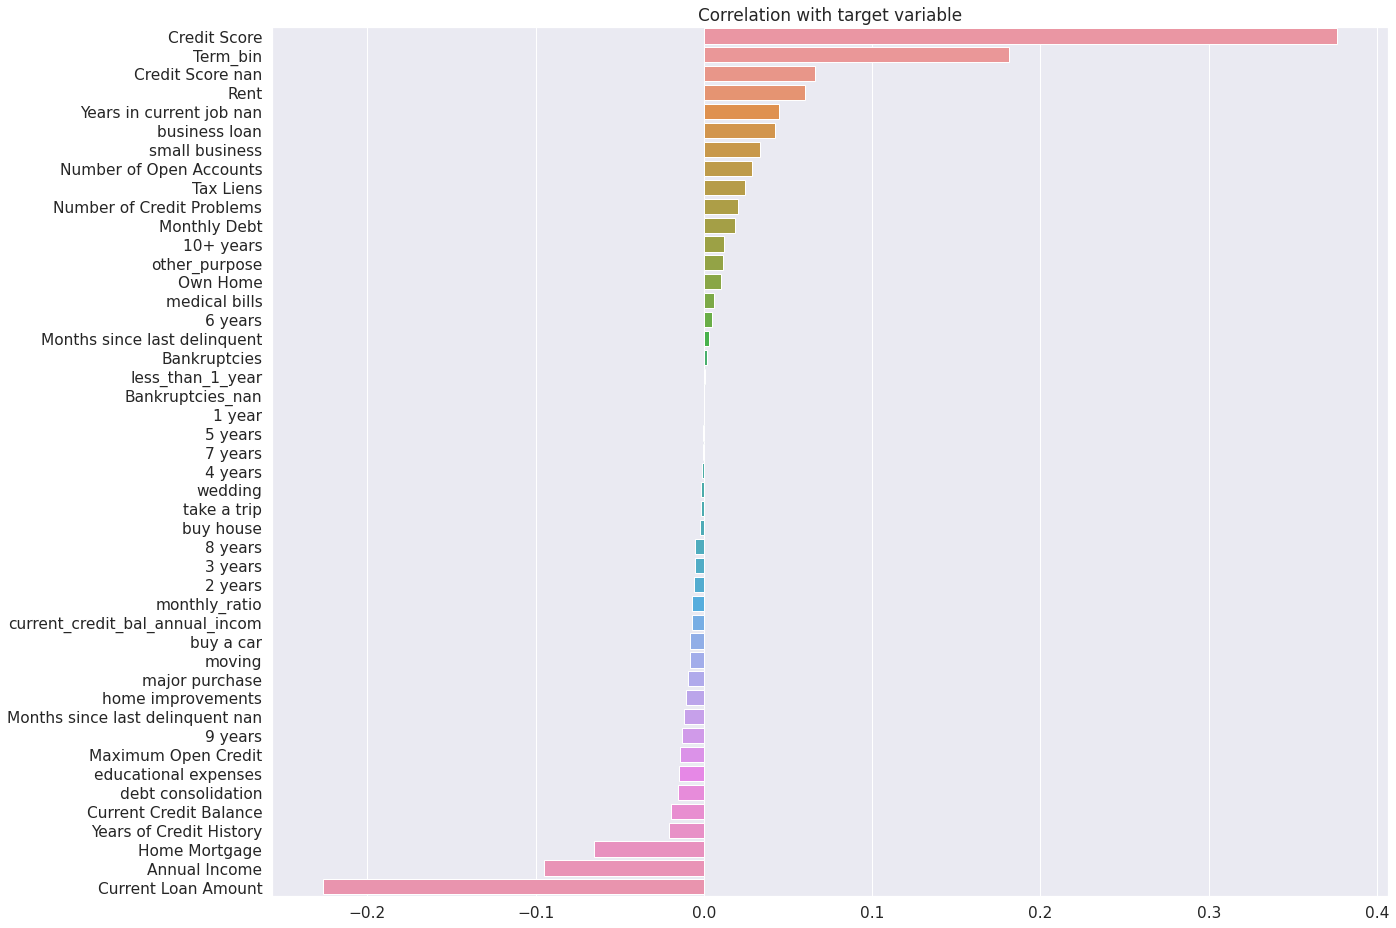

In [485]:
corr_with_target = df_train[FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(20, 16))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [486]:
non_important_features = corr_with_target[abs(corr_with_target)< 0.05]
print(non_important_features)

Years in current job nan            0.044393
business loan                       0.042531
small business                      0.033661
Number of Open Accounts             0.028884
Tax Liens                           0.024368
Number of Credit Problems           0.020088
Monthly Debt                        0.018480
10+ years                           0.012023
other_purpose                       0.011217
Own Home                            0.010260
medical bills                       0.006112
6 years                             0.005099
Months since last delinquent        0.002830
Bankruptcies                        0.001640
less_than_1_year                    0.000432
Bankruptcies_nan                    0.000383
1 year                              0.000008
5 years                            -0.000438
7 years                            -0.000751
4 years                            -0.001387
wedding                            -0.001499
take a trip                        -0.001794
buy house 

In [487]:
non_important_features = non_important_features.to_frame().T

In [488]:
non_important_features = non_important_features.columns.tolist()


In [489]:
final_features = total_num_features
for fi in non_important_features:
    final_features.remove(fi)
final_features

['Annual Income',
 'Current Loan Amount',
 'Credit Score',
 'Credit Score nan',
 'Home Mortgage',
 'Rent',
 'Term_bin']

In [490]:
scaler = MinMaxScaler(feature_range = (0,1))#RobustScaler() StandardScaler() 

df_train_norm = df_train.copy()
df_train_norm[total_num_features] = scaler.fit_transform(df_train_norm[total_num_features])
df_train = df_train_norm.copy()

In [491]:
X = df_train[final_features]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=777)

In [492]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4037
1    3176
Name: Credit Default, dtype: int64

In [493]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Финальная модель

In [494]:
model_lr = LogisticRegression(max_iter=20, solver='newton-cg', class_weight='balanced', random_state=777)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      4037
           1       0.64      0.61      0.62      3176

    accuracy                           0.68      7213
   macro avg       0.67      0.67      0.67      7213
weighted avg       0.68      0.68      0.68      7213

TEST

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1350
           1       0.49      0.63      0.55       525

    accuracy                           0.71      1875
   macro avg       0.66      0.68      0.67      1875
weighted avg       0.74      0.71      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1000  350
1                195  330


In [495]:
def df_test_preparation(df_test):
    #Пропуски
    df_test['Annual Income'] = df_test['Annual Income'].fillna(median_ai)
    df_test['Years in current job'] = df_test['Years in current job'].fillna(mode_yicj)
    df_test['Bankruptcies'] = df_test['Bankruptcies'].fillna(median_b)
    df_test['Months since last delinquent'] = df_test['Months since last delinquent'].fillna(median_msld)
    df_test['Credit Score'] = df_test['Credit Score'].fillna(median_cs)
    #New features
    df_test['monthly_ratio'] = 0
    df_test.loc[df_test['monthly_ratio'], 'monthly_ratio'] = df_test['Annual Income']/(12 * df_test['Monthly Debt'])
    
    df_test['current_credit_bal_annual_incom']=0
    df_test.loc[df_test['current_credit_bal_annual_incom'], 'current_credit_bal_annual_incom'] = df_test['Annual Income']* df_test['Current Credit Balance']
    new_features = ['monthly_ratio', 'current_credit_bal_annual_incom']
    
    #пропуски
    df_test['Years in current job nan'] = 0
    df_test.loc[df_test['Years in current job'].isna(), 'Years in current job nan'] = 1
    
    df_test['Bankruptcies_nan'] = 0
    df_test.loc[df_test['Bankruptcies'].isna(), 'Bankruptcies_nan'] = 1
    
    df_test['Months since last delinquent nan'] = 0
    df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent nan'] = 1
    
    df_test['Credit Score nan'] = 0
    df_test.loc[df_test['Credit Score'].isna(), 'Credit Score nan'] = 1
    
    df_test.replace({'Purpose': {'other': 'other_purpose', 'renewable energy' :'other_purpose', 'vacation' : 'other_purpose'}}, inplace=True)
    df_test.replace({'Years in current job': {'< 1 year': 'less_than_1_year'}}, inplace=True)
    df_test.replace({'Home Ownership': {'Have Mortgage': 'Home Mortgage'}}, inplace=True)
    
    df_bin_features_Home_Ownership = pd.get_dummies(df_test['Home Ownership'])
    df_bin_features_Years_in_current_job = pd.get_dummies(df_test['Years in current job'])
    df_bin_features_Purpose = pd.get_dummies(df_test['Purpose'])
    df_test = pd.concat([df_test, df_bin_features_Purpose, df_bin_features_Years_in_current_job, df_bin_features_Home_Ownership], axis=1)
    df_test['Term_bin'] = dummies_short_long(df_test, 'Term', 'Term_bin')
    
    scaler = MinMaxScaler(feature_range = (0,1))
    df_test_norm = df_test.copy()
    df_test_norm[total_num_features] = scaler.fit_transform(df_test_norm[total_num_features])
    df_test = df_test_norm.copy()
   

    return df_test

In [496]:
df_test = df_test_preparation(df_test)

In [497]:
X_test = df_test[final_features]

In [498]:
y_test_pred = model_lr.predict(X_test)

In [499]:
RuslanDziov_predictions = pd.DataFrame()

In [500]:
RuslanDziov_predictions['Credit Default'] = y_test_pred
RuslanDziov_predictions

,Credit Default
0,0
1,1
2,1
3,0
4,1
...,...
2495,0
2496,0
2497,0
2498,0


In [501]:
RuslanDziov_predictions.to_csv('RuslanDziov_predictions.csv', index=False)

In [502]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model_lr, file)